<a href="https://colab.research.google.com/github/giuliamf/tag_projeto2/blob/main/tag_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Preparação do Ambiente

In [1]:
!pip install pandas networkx matplotlib

2. Importação de Bibliotecas

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict


3. Leitura e Processamento dos Dados

In [3]:
!wget https://raw.githubusercontent.com/giuliamf/tag_projeto2/main/dados.txt

--2025-07-05 15:36:39--  https://raw.githubusercontent.com/giuliamf/tag_projeto2/main/dados.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6041 (5.9K) [text/plain]
Saving to: ‘dados.txt.3’

dados.txt.3         100%[===================>]   5.90K  --.-KB/s    in 0s      

2025-07-05 15:36:39 (65.5 MB/s) - ‘dados.txt.3’ saved [6041/6041]



In [4]:
with open('dados.txt', 'r', encoding='utf-8') as file:
    lines = [l.strip() for l in file.readlines() if l.strip() and not l.startswith('//')]

In [5]:
# Separar blocos de projetos e alunos
idx_alunos = next(i for i, l in enumerate(lines) if l.startswith('(A'))
projetos_raw = lines[:idx_alunos]
alunos_raw = lines[idx_alunos:]

In [6]:
# Projetos: (código, vagas, requisito mínimo)
projetos = {}
for linha in projetos_raw:
    cod, vagas, req = re.findall(r'\w+', linha)
    projetos[cod] = {'vagas': int(vagas), 'requisito': int(req)}

Dataframe de projeto - mostra o código, número de vagas e nota mínima exigida.

In [7]:
df_projetos = pd.DataFrame([
    {'Projeto': k, 'Vagas': v['vagas'], 'Nota mínima': v['requisito']}
    for k, v in projetos.items()
])

df_projetos.head()

,Projeto,Vagas,Nota mínima
0,P1,2,5
1,P2,1,5
2,P3,2,4
3,P4,1,5
4,P5,2,4


In [8]:
# Alunos: código -> preferências e nota
alunos = {}
for linha in alunos_raw:
    cod_aluno = re.search(r'\(A\d+\)', linha).group(0)[1:-1]
    preferencias = re.findall(r'P\d+', linha)
    nota = int(re.search(r'\((\d)\)', linha).group(1))
    alunos[cod_aluno] = {'preferencias': preferencias, 'nota': nota}


Dataframe de alunos - exibe o código do aluno, suas três preferências e a nota.

In [9]:
df_alunos = pd.DataFrame([
    {'Aluno': k, 'Preferências': ', '.join(v['preferencias']), 'Nota': v['nota']}
    for k, v in alunos.items()
])

df_alunos.head()

,Aluno,Preferências,Nota
0,A1,"P1, P30, P50",5
1,A2,"P1, P30, P51",5
2,A3,"P30, P34, P35",3
3,A4,"P2, P3, P5",4
4,A5,"P4, P28, P34",3


4. Filtragem de Preferências por Nota

In [10]:
preferencias_validas = defaultdict(list)

for aluno, info in alunos.items():
    nota = info['nota']
    for proj in info['preferencias']:
        if proj in projetos and nota >= projetos[proj]['requisito']:
            preferencias_validas[aluno].append(proj)

Dataframde de preferências Válidas – inclui apenas os projetos para os quais o aluno tem nota suficiente.

In [11]:
df_pref_validas = pd.DataFrame([
    {'Aluno': aluno, 'Preferências válidas': ', '.join(prefs)}
    for aluno, prefs in preferencias_validas.items()
])

df_pref_validas.head()

,Aluno,Preferências válidas
0,A1,"P1, P30, P50"
1,A2,"P1, P30"
2,A4,"P3, P5"
3,A5,P28
4,A6,"P40, P9, P10"


5. Construção do Grafo Bipartido

In [12]:
G = nx.Graph()

for aluno in preferencias_validas:
    G.add_node(aluno, bipartite=0)

for proj in projetos:
    for i in range(projetos[proj]['vagas']):
        G.add_node(f'{proj}_{i}', bipartite=1)

for aluno, prefs in preferencias_validas.items():
    for proj in prefs:
        for i in range(projetos[proj]['vagas']):
            G.add_edge(aluno, f'{proj}_{i}')


Gerar o grafo

In [13]:
# Layout bipartido
alunos_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
vagas_nodes = [n for n in G.nodes if n not in alunos_nodes]
pos = dict()
pos.update((n, (0, i)) for i, n in enumerate(alunos_nodes))  # lado esquerdo
pos.update((n, (1, i)) for i, n in enumerate(vagas_nodes))   # lado direito

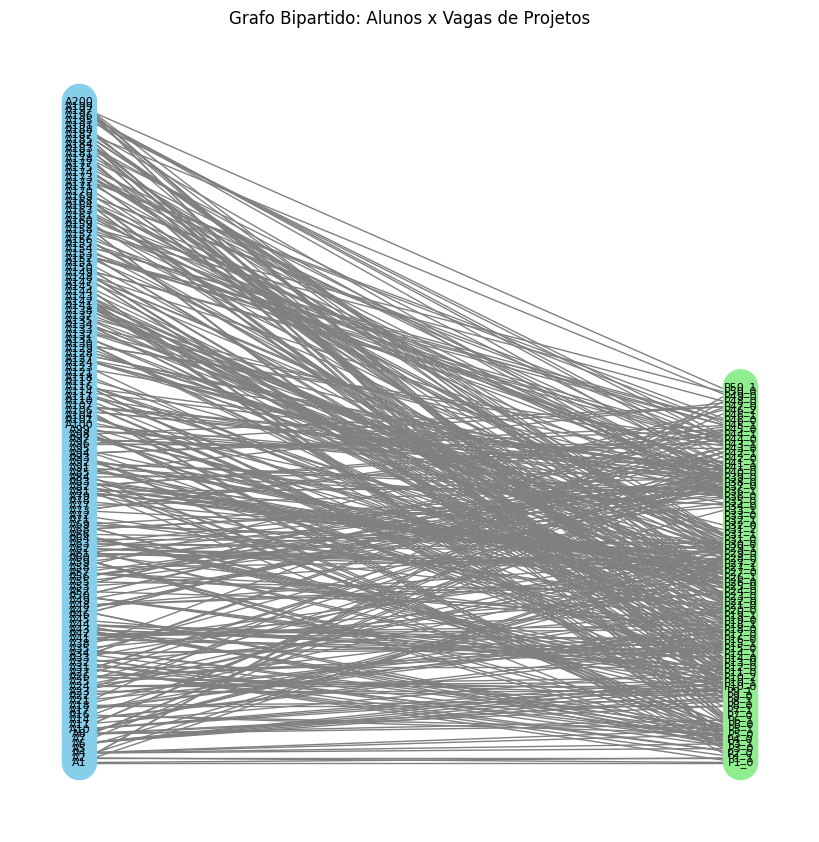

In [14]:
# Desenho do grafo
plt.figure(figsize=(8, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=['skyblue' if n in alunos_nodes else 'lightgreen' for n in G.nodes()],
    node_size=600,
    font_size=8,
    edge_color='gray'
)
plt.title('Grafo Bipartido: Alunos x Vagas de Projetos')
plt.axis('off')
plt.show()

Filtro com 10 alunos para melhor visualização do grafo

In [15]:
from networkx.algorithms import bipartite

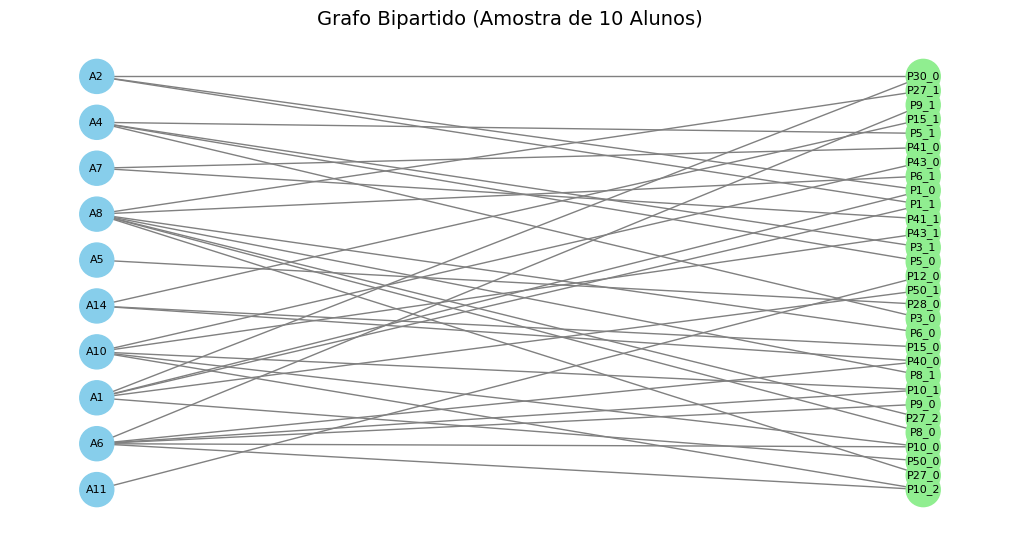

In [16]:
# Selecionar os primeiros 10 alunos
alunos_amostra = list(preferencias_validas.keys())[:10]

# Construir grafo bipartido reduzido
G_sub = nx.Graph()
for aluno in alunos_amostra:
    G_sub.add_node(aluno, bipartite=0)  # lado dos alunos
    for proj in preferencias_validas[aluno]:
        for i in range(projetos[proj]["vagas"]):
            vaga_id = f"{proj}_{i}"
            G_sub.add_node(vaga_id, bipartite=1)  # lado dos projetos (vagas)
            G_sub.add_edge(aluno, vaga_id)

# Layout bipartido com separação entre lados
aluno_nodes = [n for n, d in G_sub.nodes(data=True) if d["bipartite"] == 0]
pos = nx.bipartite_layout(G_sub, aluno_nodes)

# Desenho do grafo
plt.figure(figsize=(10, 5))
nx.draw(
    G_sub, pos,
    with_labels=True,
    node_color=["skyblue" if n in aluno_nodes else "lightgreen" for n in G_sub.nodes()],
    node_size=600,
    font_size=8,
    edge_color="gray"
)
plt.title("Grafo Bipartido (Amostra de 10 Alunos)", fontsize=14)
plt.axis("off")
plt.show()

6. Algoritmo de Emparelhamento Estável
Vamos usar uma variação do Gale-Shapley onde alunos propõem a projetos, respeitando preferências e requisitos.

In [17]:
def gale_shapley(alunos, projetos, preferencias):
    livres = list(alunos.keys())
    emparelhamento = {}
    propostas = defaultdict(set)

    while livres:
        aluno = livres.pop(0)
        prefs = preferencias[aluno]
        for proj in prefs:
            if proj in propostas[aluno]:
                continue
            propostas[aluno].add(proj)

            vagas_disponiveis = [v for v in emparelhamento if v.startswith(proj)]
            if len(vagas_disponiveis) < projetos[proj]["vagas"]:
                vaga_id = f"{proj}_{len(vagas_disponiveis)}"
                emparelhamento[vaga_id] = aluno
                break
        else:
            # não conseguiu se emparelhar com ninguém
            pass
    return emparelhamento


In [18]:
emparelhamento_final = gale_shapley(alunos, projetos, preferencias_validas)

In [19]:
resultado = []

for vaga, aluno in sorted(emparelhamento_final.items()):
    projeto = vaga.split("_")[0]
    ordem = preferencias_validas[aluno].index(projeto) + 1 if projeto in preferencias_validas[aluno] else "-"
    resultado.append({
        "Vaga": vaga,
        "Projeto": projeto,
        "Aluno": aluno,
        "Ordem de preferência": ordem
    })

df_emparelhamento = pd.DataFrame(resultado)
df_emparelhamento.head()

,Vaga,Projeto,Aluno,Ordem de preferência
0,P10_0,P10,A24,1
1,P10_1,P10,A50,2
2,P10_2,P10,A66,3
3,P11_0,P11,A45,1
4,P12_0,P12,A11,1


In [20]:
indice_total = df_emparelhamento["Ordem de preferência"].sum()
print("Índice de preferência total:", indice_total)

Índice de preferência total: 82


7. Visualização do Grafo Completo com Emparelhamento Final

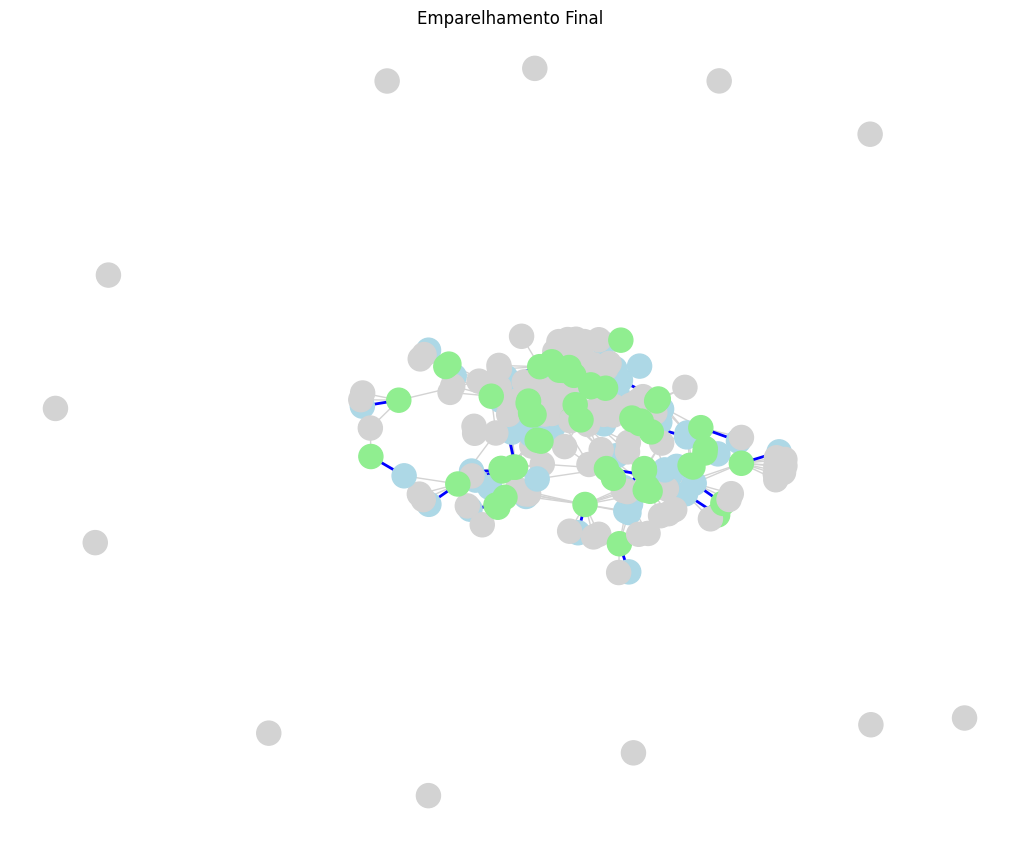

In [21]:
def visualizar_emparelhamento(grafo, emparelhamento):
    pos = nx.spring_layout(grafo, seed=42)
    cor_nos = []
    for node in grafo.nodes():
        if node in emparelhamento.values():
            cor_nos.append("lightblue")
        elif node in emparelhamento.keys():
            cor_nos.append("lightgreen")
        else:
            cor_nos.append("lightgray")

    emparelhadas = [(aluno, vaga) for vaga, aluno in emparelhamento.items()]

    plt.figure(figsize=(10, 8))
    nx.draw(
        grafo, pos,
        with_labels=False,
        node_color=cor_nos,
        node_size=300,
        font_size=6,
        edge_color="lightgray"
    )
    nx.draw_networkx_edges(
        grafo, pos,
        edgelist=emparelhadas,
        edge_color="blue",
        width=2
    )
    plt.title("Emparelhamento Final")
    plt.axis("off")
    plt.show()

# Visualizar grafo completo com emparelhamento final
visualizar_emparelhamento(G, emparelhamento_final)


✅ 8. Emparelhamento e Visualização do Grafo Filtrado (10 alunos) - para melhor visualização

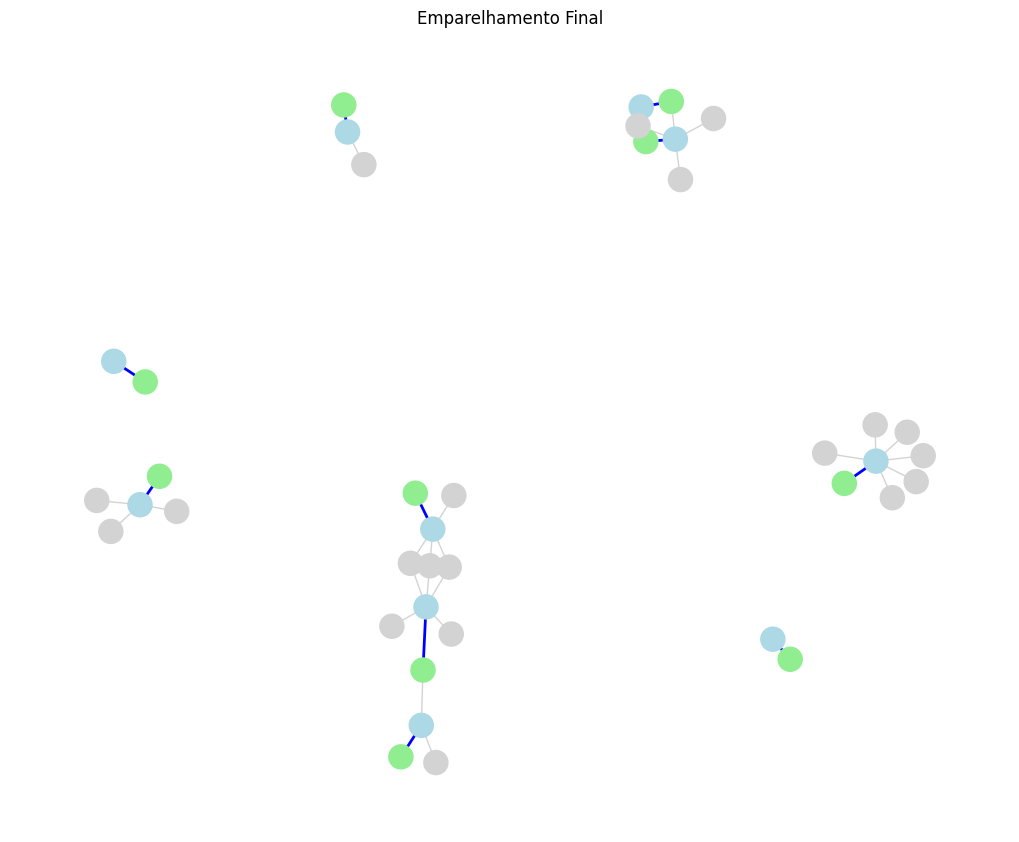

In [22]:
# Reaproveitar alunos_amostra
alunos_filtrados = {k: alunos[k] for k in alunos_amostra}
preferencias_filtradas = {k: preferencias_validas[k] for k in alunos_amostra}

# Filtrar projetos usados por esses alunos
projetos_usados = set()
for prefs in preferencias_filtradas.values():
    projetos_usados.update(prefs)
projetos_filtrados = {p: projetos[p] for p in projetos_usados}

# Rodar gale-shapley para o subconjunto
emparelhamento_filtrado = gale_shapley(alunos_filtrados, projetos_filtrados, preferencias_filtradas)

# Criar grafo reduzido
G_sub_match = nx.Graph()
for aluno in alunos_filtrados:
    G_sub_match.add_node(aluno, bipartite=0)
for proj in projetos_filtrados:
    for i in range(projetos_filtrados[proj]["vagas"]):
        vaga_id = f"{proj}_{i}"
        G_sub_match.add_node(vaga_id, bipartite=1)
for aluno, prefs in preferencias_filtradas.items():
    for proj in prefs:
        for i in range(projetos_filtrados[proj]["vagas"]):
            vaga_id = f"{proj}_{i}"
            G_sub_match.add_edge(aluno, vaga_id)

# Visualizar grafo reduzido com emparelhamento
visualizar_emparelhamento(G_sub_match, emparelhamento_filtrado)
